<a href="https://colab.research.google.com/github/lmarieta/FaceRecognition/blob/main/Face_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Before starting, upload data.h5, data_submission.h5, IdLookupTable.csv and model.h5 files. After training your model, you can download it. After saving the output file, you can also download it.

Import Libraries


In [180]:
import numpy as np
from tensorflow import keras
import tensorflow as tf
from keras import layers
import pandas as pd
import h5py
#from sklearn import train_test_split
import matplotlib.pyplot as plt
!pip install pyreadr
import pyreadr
from keras.optimizers import Adam
from timeit import default_timer
from keras.callbacks import EarlyStopping
from keras.callbacks import Callback
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape, BatchNormalization
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from collections import OrderedDict
from tensorflow.keras.models import clone_model, load_model
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from tensorflow.keras import layers, models

Initialization

In [181]:
epochs = 100
pretraining = False

Load data

In [182]:
data_filename = '/content/data.h5'
submission_filename = '/content/data_submission.h5'

## Get the indices of rows containing NaN values. Note that train and test splits are random with a given seed.
# nan_indices_train = x_train.index[x_train.isnull().any(axis=1)].tolist() + y_train.index[y_train.isnull().any(axis=1)].tolist()
# nan_indices_test = x_test.index[x_test.isnull().any(axis=1)].tolist() + y_test.index[y_test.isnull().any(axis=1)].tolist()

## Drop rows containing NaN values
# x_train = x_train.drop(x_train.index[nan_indices_train])
# y_train = y_train.drop(y_train.index[nan_indices_train])
# x_test = x_test.drop(x_test.index[nan_indices_test])
# y_test = y_test.drop(y_test.index[nan_indices_test])



In [183]:
def load(test=False, cols=None, fname=data_filename):
    """Loads data from FTEST if *test* is True, otherwise from FTRAIN.
    Pass a list of *cols* if you're only interested in a subset of the
    target columns.
    """

    with h5py.File(fname, 'r') as hdf_file:
      if (fname == data_filename and test == False):
        # Read DataFrames
        X = pd.DataFrame(hdf_file['im_train'][:])
        y = pd.DataFrame(hdf_file['d_train'][:])
        y.columns = hdf_file['d_train'].attrs['column_names']
      elif (fname == data_filename and test == True):
        # Read DataFrames
        X = pd.DataFrame(hdf_file['im_test'][:])
        y = pd.DataFrame(hdf_file['d_test'][:])
        y.columns = hdf_file['d_test'].attrs['column_names']
      else:
        # Read NumPy arrays
        X = pd.DataFrame(np.array(hdf_file['submission_image'][:]))

    if (cols and fname == data_filename):  # get a subset of columns
        y = y[list(cols)]

    X = np.vstack(X.values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if fname == data_filename:  # only FTRAIN has any target columns
        y = y.values
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X, y

In [184]:
def load2d(test=False, cols=None, fname=data_filename):
    X, y = load(test=test,cols=cols,fname=fname)
    X = X.reshape(-1, 96, 96, 1)
    return X, y

In [185]:
if pretraining == True:
  x_train, y_train = load2d(test = False, fname = data_filename)
else:
  x_train, y_train = load(test = False, fname = data_filename)
x_test, y_test = load2d(test = True, fname = data_filename)

# Find rows with NaN values
nan_rows = np.isnan(y_test).any(axis=1)

# Use boolean indexing to drop rows with NaN values
x_test = x_test[~nan_rows]
y_test = y_test[~nan_rows]

Model selection

In [186]:
model_type = 'Convolutions' # options: {'Single hidden layer','Convolutions'}
df = pd.DataFrame({model_type}, columns=['Model type'])

# Start recording time
start = default_timer()

Dynamic momentum and learning rate

In [187]:
class MomentumScheduler(Callback):
    def __init__(self, schedule, decay_rate):
        super(MomentumScheduler, self).__init__()
        self.initial_schedule = schedule
        self.decay_rate = decay_rate

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'beta_1'):
            raise ValueError("Optimizer must have a 'beta_1' attribute.")
        momentum = self.initial_schedule + (self.decay_rate*epoch) / epochs
        self.model.optimizer.beta_1 = momentum


class LinearDecayLR(Callback):
    def __init__(self, initial_lr, decay_rate):
        super(LinearDecayLR, self).__init__()
        self.initial_lr = initial_lr
        self.decay_rate = decay_rate

    def on_epoch_begin(self, epoch, logs=None):
        new_lr = self.initial_lr - (self.decay_rate * epoch) / epochs
        self.model.optimizer.lr = new_lr

# Initialize for learning rate and momentum
initial_momentum = 0.9 # TODO optimize
momentum_decay_rate = 0.999 - initial_momentum

initial_lr = 0.01 # TODO optimize
lr_decay_rate = 999 / 1000 * initial_lr

# Create callbacks
momentum_callback = MomentumScheduler(initial_momentum, momentum_decay_rate)
lr_callback = LinearDecayLR(initial_lr, lr_decay_rate)


Convolutions model

In [188]:
# Prepare for specialist training
SPECIALIST_SETTINGS = [
    dict(
        columns=(
            'left_eye_center_x', 'left_eye_center_y',
            'right_eye_center_x', 'right_eye_center_y',
            ),
        ),

    dict(
        columns=(
            'left_eye_inner_corner_x', 'left_eye_inner_corner_y',
            'left_eye_outer_corner_x', 'left_eye_outer_corner_y',
            'right_eye_inner_corner_x', 'right_eye_inner_corner_y',
            'right_eye_outer_corner_x', 'right_eye_outer_corner_y',
            ),
        ),

    dict(
        columns=(
            'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y',
            'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y',
            'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y',
            'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y',
            ),
        ),

    dict(
        columns=(
            'nose_tip_x', 'nose_tip_y',
            ),
        ),

    dict(
        columns=(
            'mouth_left_corner_x', 'mouth_left_corner_y',
            'mouth_right_corner_x', 'mouth_right_corner_y',
            'mouth_center_top_lip_x', 'mouth_center_top_lip_y',
            ),
        ),

    dict(
        columns=(
            'mouth_center_bottom_lip_x',
            'mouth_center_bottom_lip_y',
            ),
        ),
    ]

In [189]:
if pretraining == True:
  pixel_num = x_train.shape[1]

  # Find rows with NaN values
  nan_rows = np.isnan(y_train).any(axis=1)

  # Use boolean indexing to drop rows with NaN values
  x_train = x_train[~nan_rows]
  y_train = y_train[~nan_rows]

  # Assuming you have defined the input shape of your images
  input_shape = (pixel_num, pixel_num, 1)

  # Create the CNN model
  net = keras.Sequential()

  # Convolutional Layer 1
  net.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
  #net.add(BatchNormalization())
  net.add(MaxPooling2D((2, 2)))
  net.add(Dropout(0.1))

  # Convolutional Layer 2
  net.add(Conv2D(64, (2, 2), activation='relu'))
  #net.add(BatchNormalization())
  net.add(MaxPooling2D((2, 2)))
  net.add(Dropout(0.2))

  # Convolutional Layer 3
  net.add(Conv2D(128, (2, 2), activation='relu'))
  net.add(Dropout(0.2))

  # Convolutional Layer 4
  net.add(Conv2D(256, (2, 2), activation='relu'))
  net.add(BatchNormalization())
  net.add(Dropout(0.2))

  # Flatten the feature maps
  net.add(Flatten())

  # Fully Connected Layer 1
  #net.add(Dense(200, activation='relu'))
  #net.add(BatchNormalization())

  # Fully Connected Layer 2
  #net.add(Dense(200, activation='relu'))
  #net.add(BatchNormalization())

  # Output Layer
  net.add(Dense(y_train.shape[1]))

  ## Compile the model
  # net.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])

  # stop early
  early_stopping = EarlyStopping(monitor='val_loss',patience=80, restore_best_weights=True)

  # Create the Adam optimizer with the desired initial values
  optimizer = Adam(learning_rate=initial_lr, beta_1 = initial_momentum)

  # Compile the model and specify trainable variables
  net.compile(optimizer=optimizer, loss='mse', metrics=['accuracy','mse'])

  # Create a generator for training data
  batch_size = 32

  history = net.fit(x_train,
                y_train,
                batch_size = batch_size,
                epochs = epochs,
                callbacks = [early_stopping, lr_callback, momentum_callback],
                validation_data=(x_test, y_test))

  # Data augmentation
  # Create an instance of ImageDataGenerator with desired augmentation settings
  # data_generator = ImageDataGenerator(horizontal_flip = True, vertical_flip = True)


In [190]:
if pretraining == False:
  # Convolutional neural net with three convolutional layers and two fully connected layers
  keras.backend.clear_session()
  pixel_num = np.sqrt(x_train.shape[1]).astype(int)
  # Assuming you have defined the input shape of your images
  input_shape = (pixel_num, pixel_num, 1)

  # Load pre-trained model
  base_model = load_model('/content/model.h5')
  # Create the CNN model
  net = keras.Sequential()

  # Add the modified base model
  for i in range(0,13):
    net.add(base_model.layers[i])
    net.layers[0].trainable = False

  #net.layers[0].trainable = False

    # Convolutional Layer 1
  net.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
  #net.add(MaxPooling2D((2, 2)))
  net.add(Dropout(0.3))

  # Convolutional Layer 2
  net.add(Conv2D(64, (2, 2), activation='relu'))
  #net.add(MaxPooling2D((2, 2)))
  net.add(Dropout(0.5))

  # Convolutional Layer 3
  net.add(Conv2D(128, (2, 2), activation='relu'))
  net.add(Dropout(0.5))
  #net.add(BatchNormalization())


  net.load_weights('/content/model.h5',by_name=True)

  # Flatten the feature maps
  net.add(Flatten())

  # Fully Connected Layer 1
  #net.add(Dense(200, activation='relu'))
  #net.add(Dropout(0.2))

  ## Compile the model
  # net.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])

  # stop early
  early_stopping = EarlyStopping(monitor='val_loss',patience=50, restore_best_weights=True)

  # Data augmentation
  # Create an instance of ImageDataGenerator with desired augmentation settings
  # data_generator = ImageDataGenerator(horizontal_flip = True, vertical_flip = True)

  # Create a generator for training data
  batch_size = 16
  # train_generator = data_generator.flow(x_train, y_train, batch_size=batch_size)

In [191]:
specialists = OrderedDict()
val_loss_values = []
training_loss_values = []
predictions_list = []
tmp = []
tmp2 = []

def fit_specialists(fname_pretrain=None):

  for setting in SPECIALIST_SETTINGS:
    cols = setting['columns']
    x_train_cleaned, y_train_cleaned = load2d(cols=cols)
    x_test_cleaned, y_test_cleaned = load2d(test = True, cols = cols, fname = data_filename)

    # Find rows with NaN values
    nan_rows = np.isnan(y_train_cleaned).any(axis=1)

    # Use boolean indexing to drop rows with NaN values
    x_train_cleaned = x_train_cleaned[~nan_rows]
    y_train_cleaned = y_train_cleaned[~nan_rows]

    # Find rows with NaN values
    nan_rows = np.isnan(y_test_cleaned).any(axis=1)

    # Use boolean indexing to drop rows with NaN values
    x_test_cleaned = x_test_cleaned[~nan_rows]
    y_test_cleaned = y_test_cleaned[~nan_rows]

    model = clone_model(net)
    # Output Layer
    model.add(Dense(y_train_cleaned.shape[1]))

    if 'kwargs' in setting:
        # an option 'kwargs' in the settings list may be used to
        # set any other parameter of the net:
        vars(model).update(setting['kwargs'])

    # Create the Adam optimizer with the desired initial values
    optimizer = Adam(learning_rate=initial_lr, beta_1 = initial_momentum, clipvalue = 1)

    # Compile the model and specify trainable variables
    model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])

    print("Training model for columns {} for {} epochs".format(
        cols, epochs))

    history = model.fit(x_train_cleaned,
              y_train_cleaned,
              batch_size = batch_size,
              epochs = epochs,
              callbacks = [early_stopping, lr_callback, momentum_callback],
              validation_data=(x_test_cleaned, y_test_cleaned))
    specialists[cols] = model

    # Calculate and store the loss value for this specialist
    val_loss = history.history['val_loss']
    training_loss = history.history['loss']
    val_loss_values.append((cols, val_loss))
    training_loss_values.append((cols, training_loss))

    # Make predictions using this specialist on the cleaned test data
    predictions = model.predict(x_test)
    predictions_list.append(predictions)

Analysis

In [192]:
if pretraining == False:
  fit_specialists()

  # Combine predictions from all specialists
  combined_predictions = np.hstack(predictions_list)
else:
  combined_predictions = net.predict(x_test)
  # Save the model to a file
  net.save('/content/model.h5')

# Calculate the loss value for the combined predictions
combined_loss = mean_squared_error(y_test, combined_predictions)

# Duration
duration = default_timer() - start
print(duration)
df['Duration'] = duration

Training model for columns ('left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y') for 100 epochs
Epoch 1/100
352/352 [==============================] - 10s 17ms/step - loss: 348.3402 - accuracy: 0.9860 - val_loss: 288963.2188 - val_accuracy: 0.9950
Epoch 2/100
352/352 [==============================] - 5s 14ms/step - loss: 89.1957 - accuracy: 0.9957 - val_loss: 94583.5625 - val_accuracy: 0.9950
Epoch 3/100
352/352 [==============================] - 7s 19ms/step - loss: 57.2680 - accuracy: 0.9957 - val_loss: 114021.5625 - val_accuracy: 0.9950
Epoch 4/100
352/352 [==============================] - 6s 17ms/step - loss: 53.2124 - accuracy: 0.9957 - val_loss: 132271.5000 - val_accuracy: 0.9950
Epoch 5/100
352/352 [==============================] - 6s 17ms/step - loss: 43.1641 - accuracy: 0.9957 - val_loss: 78641.7656 - val_accuracy: 0.9950
Epoch 6/100
352/352 [==============================] - 5s 14ms/step - loss: 37.8645 - accuracy: 0.9957 - val_loss: 72166.

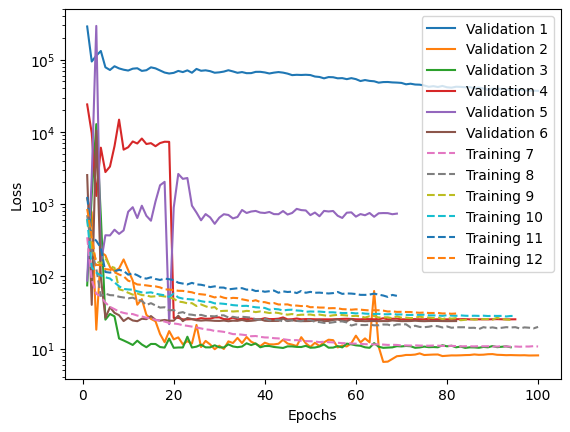

In [193]:
plt.figure()
i = 1
for index, value in enumerate(val_loss_values):
    plt.plot(range(1, len(value[1])+1), value[1], label='Validation ' + str(i))
    i+=1
for index, value in enumerate(training_loss_values):
    plt.plot(range(1, len(value[1])+1), value[1], label='Training ' + str(i),linestyle='--')
    i+=1
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [194]:
# First, calculate the column means along axis 0 (columns)
col_means = np.nanmean(y_test, axis=0)

# Next, create the matrix 'p' using the calculated column means
num_rows_d_test = y_test.shape[0]
num_cols_d_train = y_train.shape[1]

# Print RMSE
print('RMSE : ')
print(combined_loss)
df['RMSE'] = combined_loss
df.to_csv('/content/performance.csv',mode='a')

RMSE : 
5526.0205


In [195]:
df_predictions = pd.DataFrame(combined_predictions)

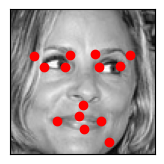

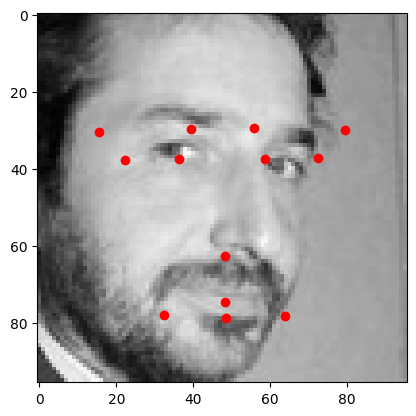

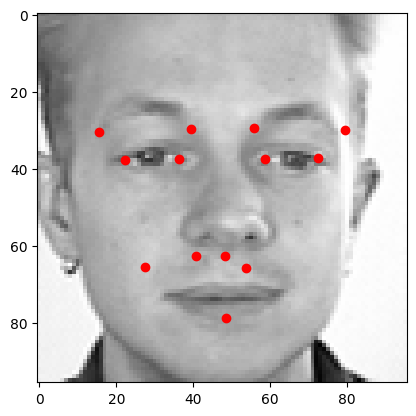

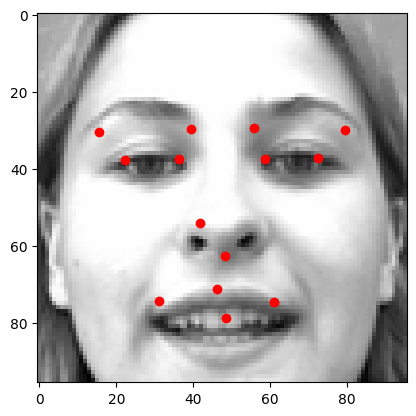

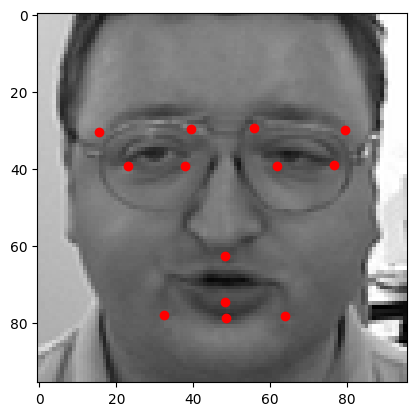

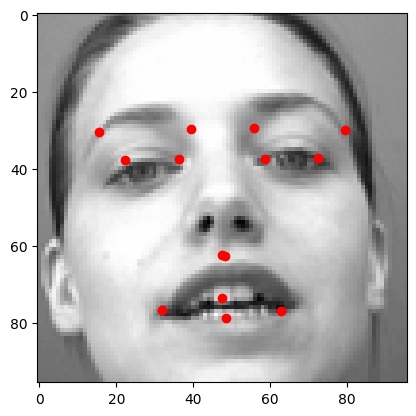

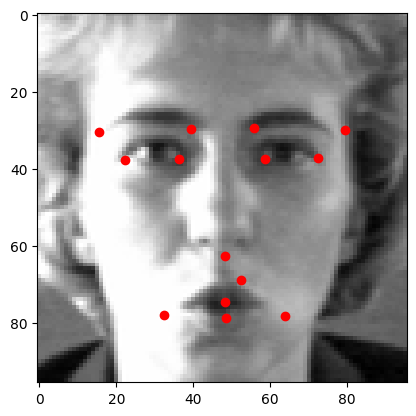

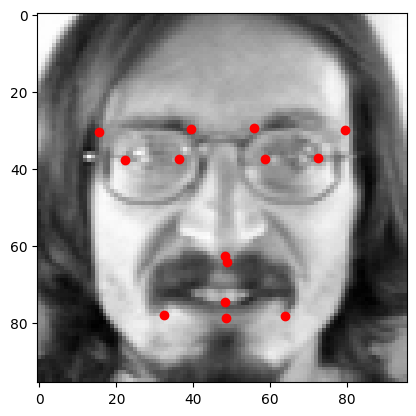

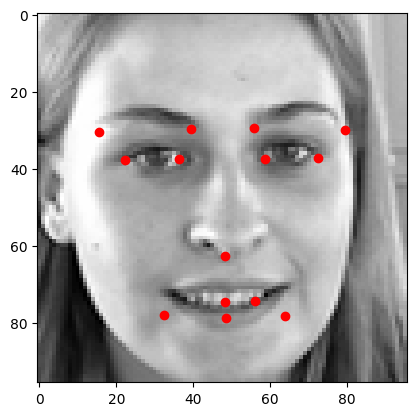

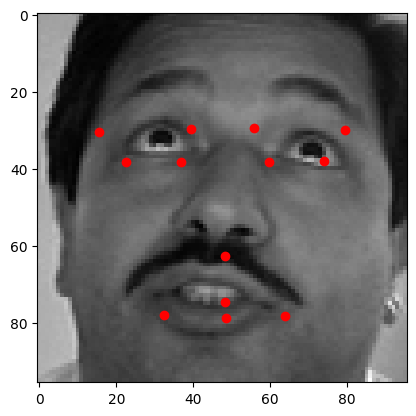

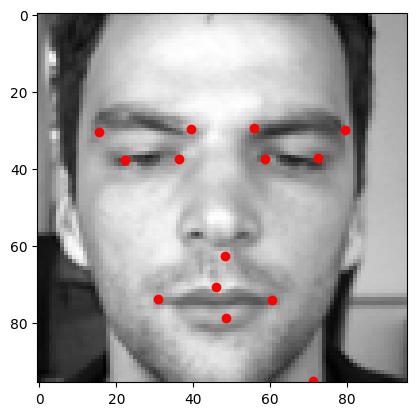

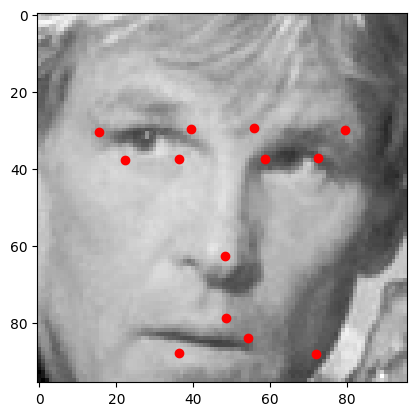

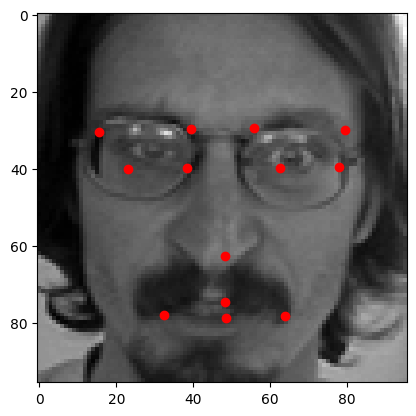

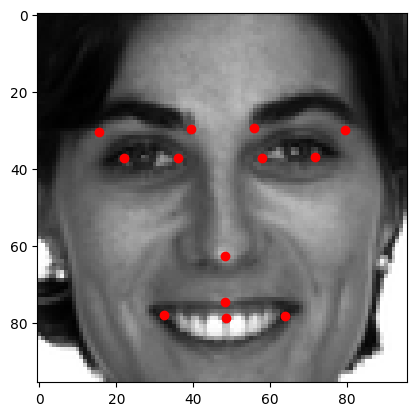

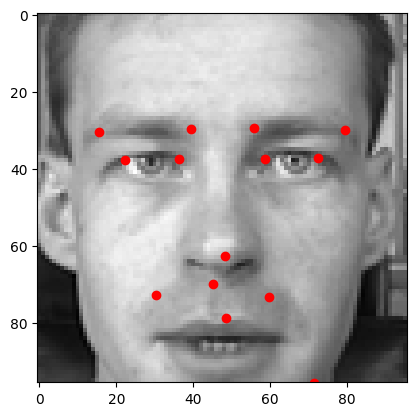

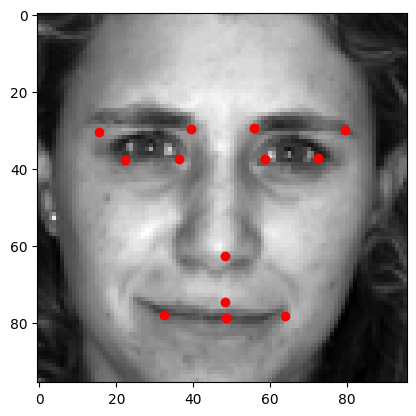

In [196]:
# Plot the first 16 images in the DataFrame

fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
  if model_type == 'Single hidden layer':
    image = np.array(x_test.iloc[i,:])  # Convert the Series to a NumPy array
    image = image.reshape((96, 96))  # Reshape the array to the desired image dimensions
  elif model_type == 'Convolutions':
    image = x_test[i]
    image = image.reshape((96, 96))
  ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
  predicted_keypoints = combined_predictions[i].reshape((15, 2))
  plt.scatter(predicted_keypoints[:, 0], predicted_keypoints[:, 1], c='r', marker='o')
  plt.imshow(image, cmap='gray')
  plt.show()

56/56 [==============================] - 0s 4ms/step


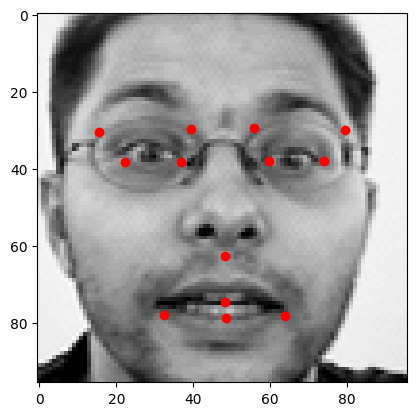

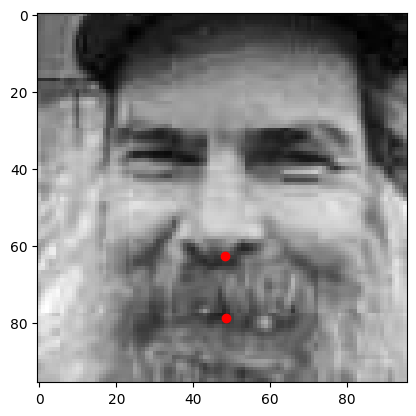

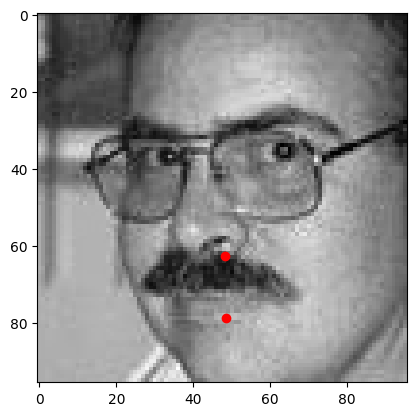

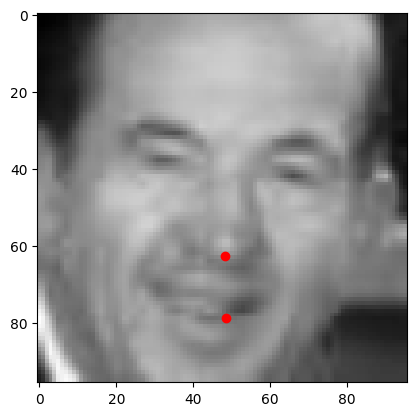

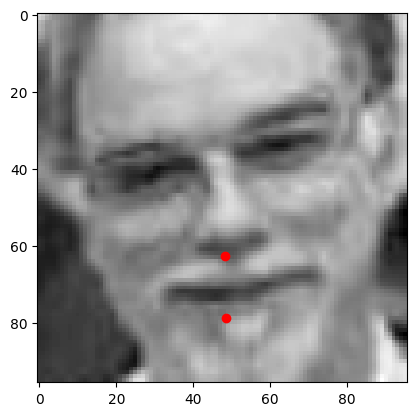

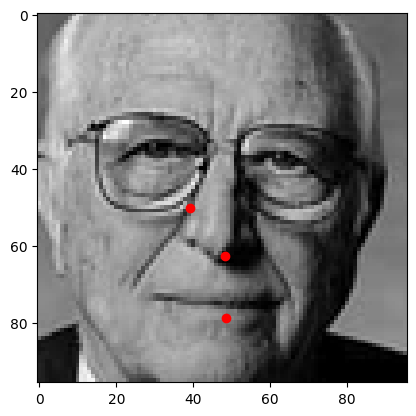

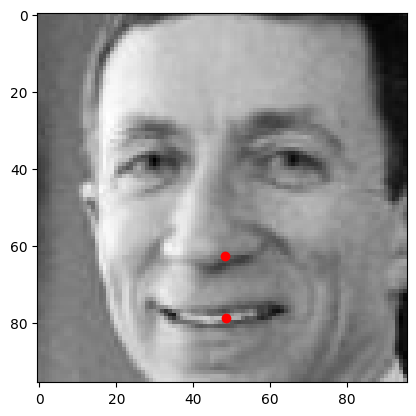

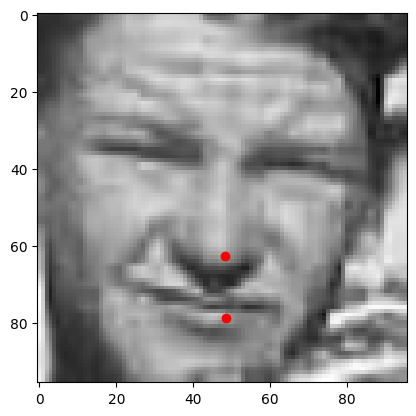

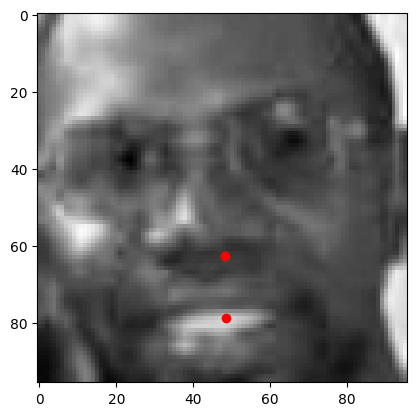

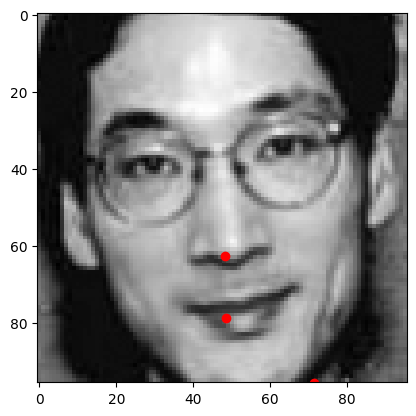

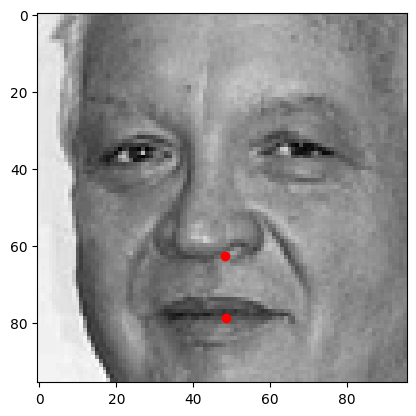

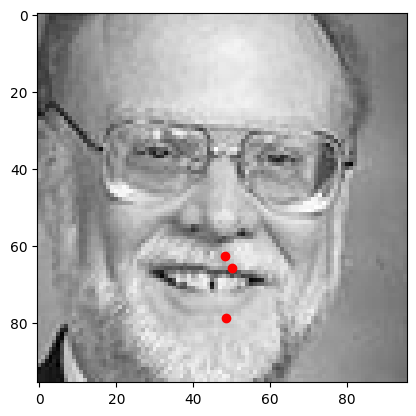

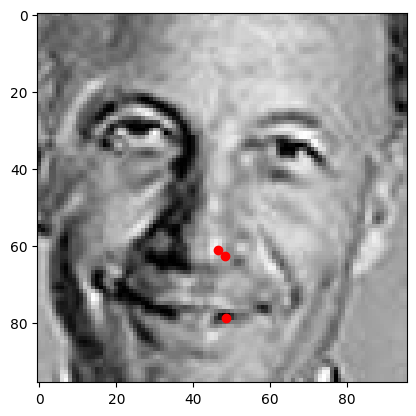

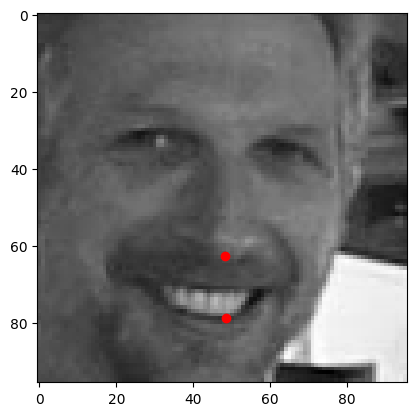

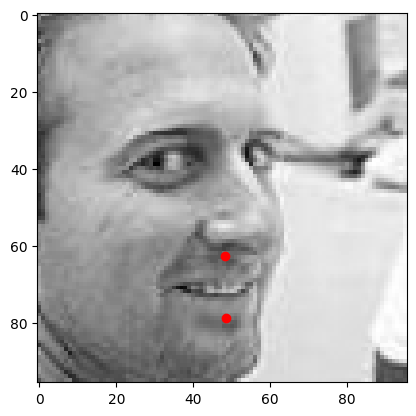

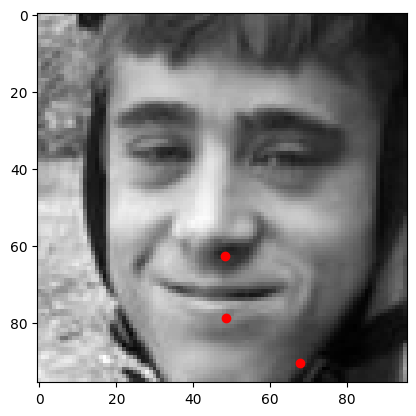

In [197]:
#TODO move below
# from pandas.io.parsers.readers import read_csv
# Extract data for output
x_submission = load2d(fname = submission_filename)
if pretraining == False:
  submission_predictions_list = []

  for setting in SPECIALIST_SETTINGS:
      cols = setting['columns']
      x_submission, _ = load2d(cols=cols,fname = submission_filename)

      # Make predictions using this specialist on the cleaned test data
      submission_predictions = specialists[cols].predict(x_submission)
      submission_predictions_list.append(submission_predictions)

  # Make predictions
  predictions_submission = np.hstack(submission_predictions_list)
else:
  x_submission, _ = load2d(fname = submission_filename)
  predictions_submission = net.predict(x_submission)
# Remove predictions not requested in IdLookupTable.csv
filename = '/content/IdLookupTable.csv'
IdLookupTable = pd.read_csv(filename)
# All keypoints names
keypoints_names = IdLookupTable['FeatureName'].iloc[0:30]
# Calculate the repeating sequence based on the number of rows in 'df'
repeating_sequence = np.repeat(np.arange(1, 1783*30 // 30 + 1), 30)
# Add the repeating sequence as a new column to the DataFrame
keypoints_names_filter = pd.DataFrame({'ImageId': repeating_sequence})
keypoints_names_filter['Indices'] = range(len(keypoints_names_filter))
keypoints_names_filter['FeatureName'] = pd.concat([keypoints_names] * 1783, ignore_index=True)
# Filter
keypoints_names_filter = keypoints_names_filter.merge(IdLookupTable[['ImageId', 'FeatureName']], on=['ImageId', 'FeatureName'], how='inner')
# Create a mask of size 1783x30 where True indicates the indices to keep
nb_output_images = x_submission.shape[0]
mask = np.isin(np.arange(nb_output_images*30), keypoints_names_filter['Indices'])
# Reshape the mask to the same shape as 'np_array'
mask = mask.reshape(predictions_submission.shape)
# Use the mask to replace values in the NumPy array with NaN
predictions_submission[~mask] = np.nan

# Plot the first image in the DataFrame
for i in range(16):
  if model_type == 'Single hidden layer':
    image = np.array(x_submission.iloc[-i,:])
    image = image.reshape((96, 96))  # Reshape the array to the desired image dimensions
  elif model_type == 'Convolutions':
    image = x_submission[-i]
    image = image.reshape((96, 96))
  predicted_keypoints = predictions_submission[-i].reshape((15, 2))
  plt.scatter(predicted_keypoints[:, 0], predicted_keypoints[:, 1], c='r', marker='o')
  plt.imshow(image, cmap='gray')
  plt.show()

# Prepare for output file
df_predictions = pd.DataFrame(predictions_submission)

# Convert the DataFrame to a NumPy array and reshape it
reshaped_values = df_predictions.values.reshape(-1, 1)

# Remove NaN values from the NumPy array
reshaped_values = reshaped_values[~np.isnan(reshaped_values)]

# Create a new DataFrame with the reshaped values
reshaped_df = pd.DataFrame(reshaped_values, columns=['Value'])
indices = pd.DataFrame(range(1,len(reshaped_df)+1))
submission = pd.concat([indices, reshaped_df], axis=1)
submission.rename(columns={0: 'RowId','Value': 'Location'}, inplace=True)

# Write to csv file
submission.to_csv('/content/model_submission.csv',index=False)
